In [1]:
import pandas as pd

In [28]:
!pip install pyalgotrade

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/trader/data_2020_2023_5min.csv"
df = pd.read_csv(path)

In [5]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

In [6]:
df1 = df.rename(columns={
    'datetime': 'Date Time',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [7]:
df1.head()

,Date Time,Open,High,Low,Close,Volume
0,2020-01-01T05:30:00.000Z,7195.24,7196.25,7178.64,7179.78,95.509133
1,2020-01-01T05:35:00.000Z,7179.76,7191.77,7178.20,7191.07,59.365225
2,2020-01-01T05:40:00.000Z,7193.15,7193.53,7180.24,7180.97,48.068510
3,2020-01-01T05:45:00.000Z,7180.97,7186.40,7177.35,7178.29,32.192929
4,2020-01-01T05:50:00.000Z,7177.71,7182.46,7175.47,7176.96,49.027397


In [8]:
df1.to_csv('data.csv', index=False)

In [31]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import datetime

INFO:strategy:Final portfolio value: $1500933.928442007
2024-09-29 19:56:29,868 strategy [INFO] Final portfolio value: $1500933.928442007


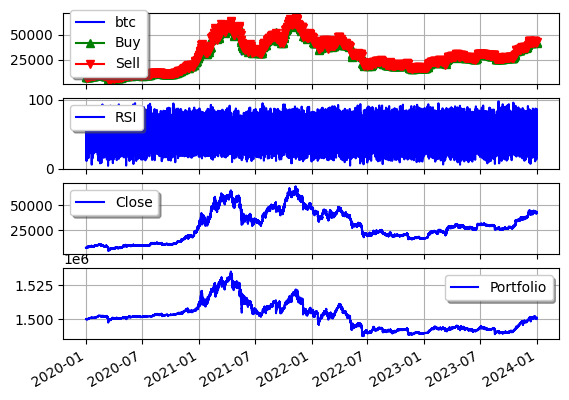

In [15]:
from pyalgotrade.technical import rsi as indicators 
class SwingTradingStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, rsiPeriod):
        super(SwingTradingStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__rsi = indicators.RSI(feed[instrument].getPriceDataSeries(), rsiPeriod)
        self.__position = None

    def onBars(self, bars):
        if self.__rsi[-1] is None:
            return

        current_price = bars[self.__instrument].getClose()

        if self.__position is None and self.__rsi[-1] < 30:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and self.__rsi[-1] > 70:
            self.__position.exitMarket()
            self.__position = None

    def getRsi(self):
        return self.__rsi

def run_swing_trading_strategy(rsiPeriod):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = SwingTradingStrategy(feed, "btc", broker, rsiPeriod)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("RSI").addDataSeries("RSI", myStrategy.getRsi())
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

# Example usage
run_swing_trading_strategy(rsiPeriod=14)

DEBUG:broker.backtesting:Not enough volume to fill btc market order [17036] for 1 share/s
2021-02-11 08:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [17036] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [17036] for 1 share/s
2021-02-11 08:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [17036] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [17036] for 1 share/s
2021-02-11 09:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [17036] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [17036] for 1 share/s
2021-02-11 09:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [17036] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [17036] for 1 share/s
2021-02-11 09:10:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [17036] for 

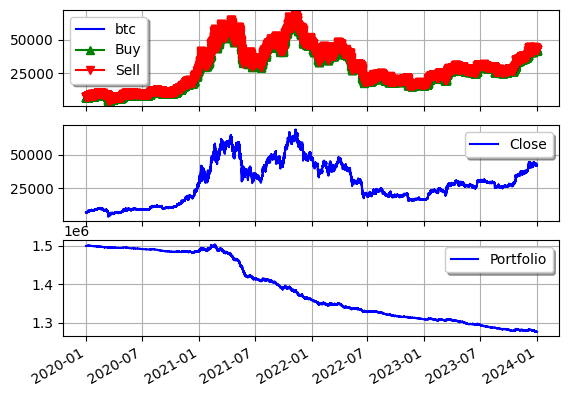

In [16]:

from pyalgotrade import strategy

class TimeSeriesMomentum(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, period, broker):
        super(TimeSeriesMomentum, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__period = period
        self.__position = None

    def onBars(self, bars):
        if len(self.__prices) < self.__period:
            return

        bar = bars[self.__instrument]
        current_price = bar.getClose()
        past_price = self.__prices[-self.__period]
        if self.__position is None and current_price > past_price:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and current_price < past_price:
            self.__position.exitMarket()
            self.__position = None
def run_time_series_momentum_strategy(period):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = TimeSeriesMomentum(feed, "btc", period, broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()
run_time_series_momentum_strategy(period=14)


INFO:strategy:Final portfolio value: $1500933.928442007
2024-09-29 20:00:21,496 strategy [INFO] Final portfolio value: $1500933.928442007


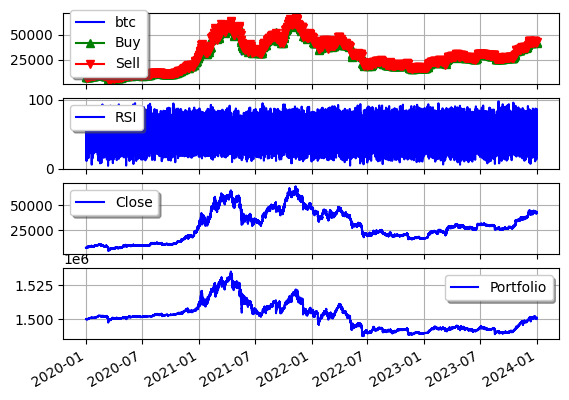

In [19]:


from pyalgotrade.technical import rsi

class MomentumReversal(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, rsiPeriod, overbought, oversold, broker):
        super(MomentumReversal, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__rsi = rsi.RSI(feed[instrument].getPriceDataSeries(), rsiPeriod)
        self.__overbought = overbought
        self.__oversold = oversold
        self.__position = None

    def onBars(self, bars):
        if self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None and self.__rsi[-1] < self.__oversold:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and self.__rsi[-1] > self.__overbought:
            self.__position.exitMarket()
            self.__position = None

    def getRsi(self):
        return self.__rsi  

def run_momentum_reversal_strategy(rsiPeriod, overbought, oversold):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = MomentumReversal(feed, "btc", rsiPeriod, overbought, oversold, broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("RSI").addDataSeries("RSI", myStrategy.getRsi())
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_momentum_reversal_strategy(rsiPeriod=14, overbought=70, oversold=30)


INFO:strategy:Final portfolio value: $1499832.4679710022
2024-09-29 20:01:43,050 strategy [INFO] Final portfolio value: $1499832.4679710022


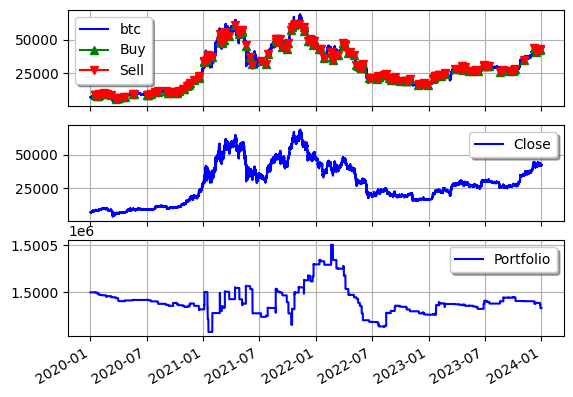

In [20]:
from pyalgotrade import strategy
from pyalgotrade.technical import rsi

class HarmonicPatternsStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(HarmonicPatternsStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__position = None
        self.__prices = []

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.__prices.append(bar.getClose())

        if len(self.__prices) < 5:
            return  
        if self.detect_harmonic_pattern():
            if self.__position is None:
                self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None:
            self.__position.exitMarket()
            self.__position = None

    def detect_harmonic_pattern(self):
        if len(self.__prices) < 5:
            return False

        X = self.__prices[-5]
        A = self.__prices[-4]
        B = self.__prices[-3]
        C = self.__prices[-2]
        D = self.__prices[-1]

        if A < X and B < A and C > A and D > C:
            if 0.618 <= (C - A) / (X - A) <= 0.786 and 1.618 <= (D - B) / (A - B) <= 2.618:
                return True
        return False
def run_harmonic_patterns_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = HarmonicPatternsStrategy(feed, "btc", broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_harmonic_patterns_strategy()


DEBUG:broker.backtesting:Not enough volume to fill btc market order [7135] for 1 share/s
2020-02-19 17:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [7135] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [58363] for 1 share/s
2021-02-11 07:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [58363] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [58363] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [58363] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [58363] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [58363] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [58363] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [58363] for 1 

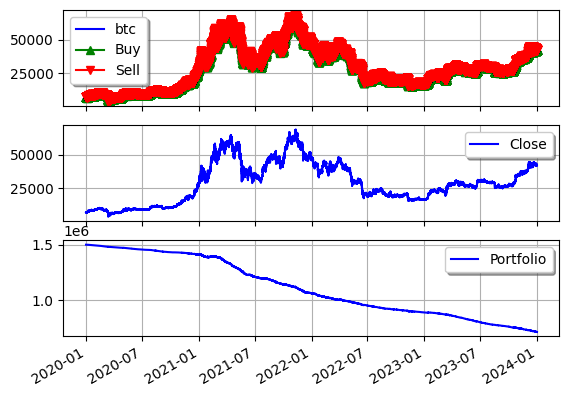

In [21]:
from pyalgotrade import strategy

class PointAndFigureStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, boxSize, reversalSize, broker):
        super(PointAndFigureStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__boxSize = boxSize
        self.__reversalSize = reversalSize
        self.__position = None
        self.__last_price = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        current_price = bar.getClose()

        if self.__last_price is None:
            self.__last_price = current_price
            return

        if self.__position is None and (current_price - self.__last_price) >= self.__boxSize:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and (self.__last_price - current_price) >= self.__boxSize:
            self.__position.exitMarket()
            self.__position = None
        self.__last_price = current_price
def run_point_and_figure_strategy(boxSize, reversalSize):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = PointAndFigureStrategy(feed, "btc", boxSize, reversalSize, broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_point_and_figure_strategy(boxSize=1, reversalSize=3)


In [33]:
from pyalgotrade import bar


DEBUG:broker.backtesting:Not enough volume to fill btc market order [6929] for 1 share/s
2020-02-19 17:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [6929] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56694] for 1 share/s
2021-02-11 07:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56694] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56694] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56694] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56694] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56694] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56694] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56694] for 1 

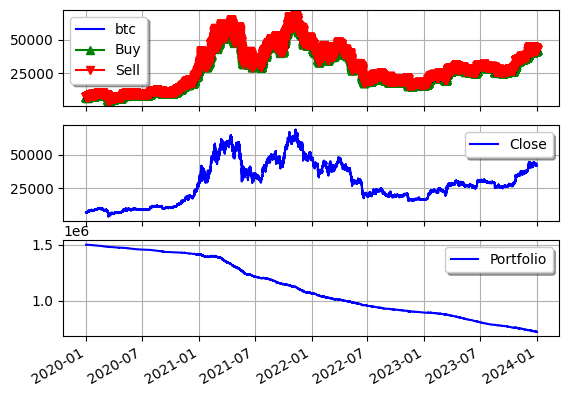

In [39]:

class RenkoBar:
    def __init__(self, direction, price):
        self.direction = direction  # 1 for upward, -1 for downward
        self.price = price

class RenkoBarFeed:
    def __init__(self, box_size):
        self.box_size = box_size
        self.renko_bars = []
        self.previous_price = None

    def add_price_data(self, price):
        if self.previous_price is None:
            self.previous_price = price
            return

        price_movement = price - self.previous_price
        if price_movement >= self.box_size:
            num_bricks = int(price_movement // self.box_size)
            for _ in range(num_bricks):
                self.renko_bars.append(RenkoBar(1, self.previous_price + self.box_size * (_ + 1)))
            self.previous_price += num_bricks * self.box_size
        elif price_movement <= -self.box_size:
            num_bricks = int(-price_movement // self.box_size)
            for _ in range(num_bricks):
                self.renko_bars.append(RenkoBar(-1, self.previous_price - self.box_size * (_ + 1)))
            self.previous_price -= num_bricks * self.box_size

    def get_last_renko_bar(self):
        if self.renko_bars:
            return self.renko_bars[-1]
        return None

class RenkoStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument, broker, box_size):
        super(RenkoStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__renko_feed = RenkoBarFeed(box_size)
        self.__position = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.__renko_feed.add_price_data(bar.getClose())  # Add the current price to the Renko feed

        last_renko_bar = self.__renko_feed.get_last_renko_bar()
        if self.__position is None:
            if last_renko_bar is not None and last_renko_bar.direction == 1:
                self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position.getShares() > 0:
            if last_renko_bar is not None and last_renko_bar.direction == -1:
                self.__position.exitMarket()
                self.__position = None

def run_strategy(box_size):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = RenkoStrategy(feed, "btc", broker, box_size)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(box_size=1)
